# Estimating Fourth Down Conversation Success

---
embed-resources: true
---

## Introduction


In this report, we develop a model to estimate the probability of success when attempting to convert on fourth down.
This model could be used within a larger win probability system, but it is limited to estimating the probability of success when attempting to convert.
It does not consider other decisions such as whether to punt, kick a field, or attempt to convert.

## Methods

In [1]:
# basic
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump
import itertools

# machine learning
from sklearn.ensemble import RandomForestClassifier

### Data

In [2]:
# import data
football_train = pd.read_parquet(
    "https://cs307.org/lab/data/football-train.parquet",
)
football_test = pd.read_parquet(
    "https://cs307.org/lab/data/football-test.parquet",
)

The train data contains one row per fourth-down conversion attempt in the 2019, 2020, and 2021 NFL seasons.
The test data contains one row per fourth-down conversion attempt in the 2022 NFL season.
The variables considered are:

#### Response

**`converted`**

- `[category]` Result of fourth-down conversion attempt. One of `['No', 'Yes']`.

#### Features

`togo`

- `[float64]` Distance in yards to the first down marker or the end zone, which is the distance needed to successfully convert the fourth-down attempt.

`yardline`

- `[float64]` Distance in yards from the opponent's end zone, which is the distance needed to score a touchdown.

`play_type`

- `[category]` Type of play. One of `['Pass', 'Run']`. Pass plays include sacks. Run plays includes scrambles.

In [3]:
# calculate summary statistics
(
    football_train["converted"]
    .agg(["value_counts", lambda x: x.value_counts(normalize=True)])
    .rename(
        columns={
            "value_counts": "Count",
            "<lambda>": "Proportion",
        },
    )
    .rename_axis("Converted?")
)

,Count,Proportion
Converted?,,
Yes,1030,0.517588
No,960,0.482412


We see that conversion success, given no additional information, is a bitter better than a coin-flip, at 52%.

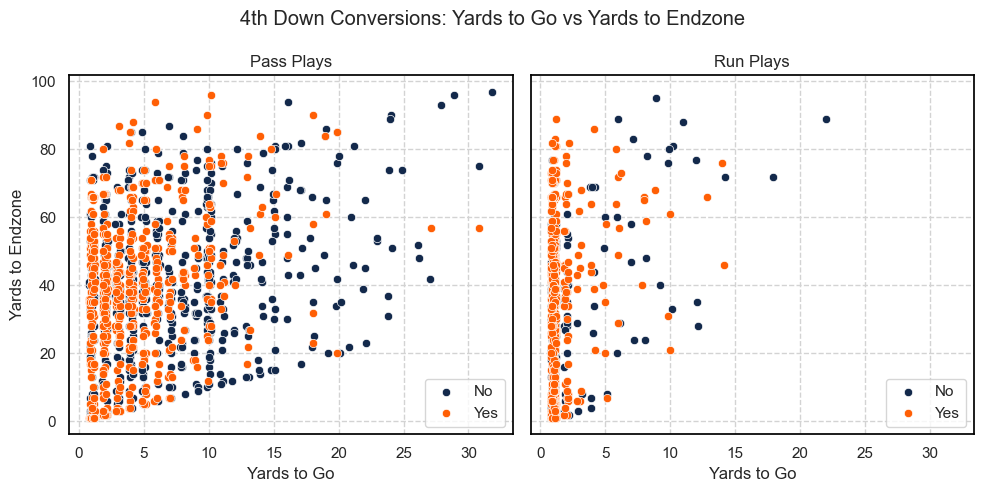

In [4]:
# define a custom color palette
custom_palette = ["#13294B", "#FF5F05"]
sns.set_theme(style="whitegrid")


# function to add jitter to x values
def add_jitter(data, jitter_amount=0.2):
    return data + np.random.uniform(
        -jitter_amount,
        jitter_amount,
        size=data.shape,
    )


# set the figure size using height and aspect
g = sns.FacetGrid(
    football_train,
    col="play_type",
    hue="converted",
    height=5,
    palette=custom_palette,
    legend_out=False,
)
g.map_dataframe(
    sns.scatterplot,
    x=add_jitter(football_train["togo"]),
    y="yardline",
)

# add a legend for each subplot
g.add_legend(title="Conversion Status")

# modify axis labels and titles
g.set_axis_labels("Yards to Go", "Yards to Endzone")
g.set_titles(col_template="{col_name} Plays")

# adjust the legend location within each subplot
for ax in g.axes.flat:
    ax.legend(loc="lower right")
    ax.grid(True, which="both", linestyle="--", color="lightgrey")
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.25)
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

# add an overall title to the plot
g.figure.suptitle("4th Down Conversions: Yards to Go vs Yards to Endzone")

# adjust the layout to make room for the overall title
g.figure.tight_layout(rect=[0, 0, 1, 1])

Breaking down the data by yards to go, yards to the end zone, and play type (pass versus rush), some obvious patterns emerge.
Pass plays are far more common when attempting a fourth down conversion in recent years.
Run plays are especially uncommon for any situation with more than two yards to go.
This could be a limited factor for any model we create.
We also notice that it seems success is more likely with fewer yards to go.
It appears that running is slightly more successful than passing with one yard to go.


### Models

In [5]:
# create X and y for train
X_train = football_train.drop(columns=["converted"])
X_train = pd.get_dummies(X_train, dtype=float, drop_first=True)
y_train = football_train["converted"]

# create X and y for test
X_test = football_test.drop(columns=["converted"])
X_test = pd.get_dummies(X_test, dtype=float, drop_first=True)
y_test = football_test["converted"]

In [6]:
# initialize model
mod = RandomForestClassifier(
    n_estimators=25,
    random_state=42,
    max_depth=5,
)

# fit model
_ = mod.fit(X_train, y_train)

We consider a single untuned model, a random forest.

## Results

In [7]:
# calculate test accuracy
y_pred_test = mod.predict(X_test)
accuracy_test = np.mean(y_test == y_pred_test)
accuracy_test.item()

0.6150943396226415

The selected model achieves a test accuracy of 0.615.

In [8]:
# serialize model
dump(mod, "football.joblib")

['football.joblib']

## Discussion

While a test accuracy of 0.615 is indeed better than the baseline of 0.52, this model is still of limited use.
A single metric like accuracy is insufficient to evaluate this model for its stated purpose.
An accuracy of 0.615 is not suggestive of the underlying probabilities produced by the model, which would be the most relevant information produced by the model for use in a system that attempts to estimate win probability.

To truly evaluate its performance, we would need to validate the *probabilities* rather than the overall prediction accuracy.
An estimated conversion probability of both 0.51 and 0.99 correspond to predictions of success, but with very different confidences.
In most game situations, a 0.99 success probability almost certainly justifies the decision to go-for-it on fourth down.
However, in other game situations, a 0.51 success probability might suggest that other options, such as punting or kicking a field goal, would be increase overall win probability.
Without evaluating the probabilities, using this model would risk making poorly informed in-game decision.

In addition to evaluating the model based on the probabilities that it produces, there are some other obvious improvements that should be considered here.
The model would likely be improved by considering additional inputs such as the time remaining in the game, and most importantly, a measure of skill of the offense and defense that completed the plays in the data.
That is, we expect a "good" offense to have a higher success rate than a "bad" offense, modified according to the strength of the defense.

We should also note that this model currently assumes that future seasons will have similar conversion success as compared to past seasons.
While this is not a completely unreasonable assumption, if rules change or the metagame shifts (teams change play-style as a reaction to current play-styles of other teams), we should suspect that future predictions will be less reliable.

The following graphic provides some minimal validation of the output probabilities.
We see that they are relatively internally consistent.
For example, we see the conversion probability decrease as yards to go increases, which is expected.
However, we would still need to evaluate the specific values calculated as the apply to the corresponding game situations.

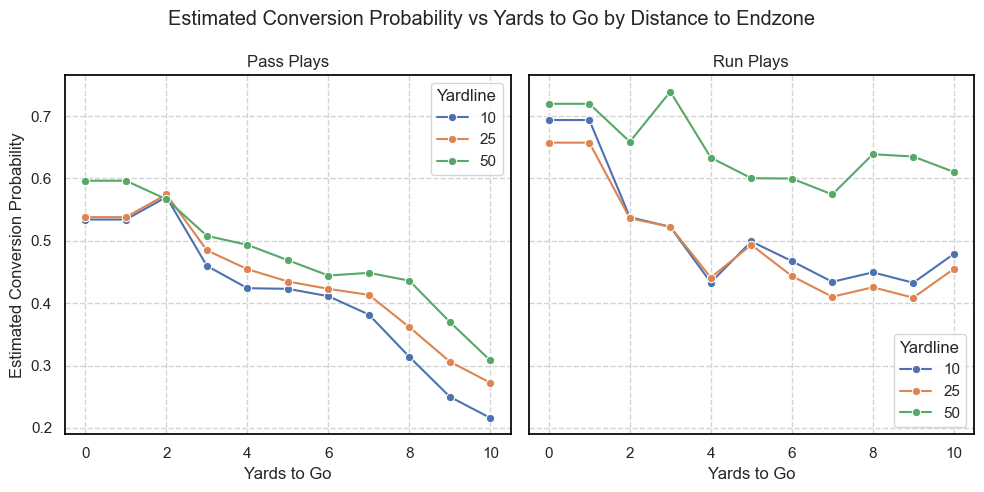

In [9]:
# create data that span both play types, many togo values, various field positions
togo = list(range(0, 11))
yardline = [10, 25, 50]
play_type_Run = [0, 1]
product = list(itertools.product(togo, yardline, play_type_Run))
new_data = pd.DataFrame(
    product,
    columns=[
        "togo",
        "yardline",
        "play_type_Run",
    ],
)
new_data["yardline"] = new_data["yardline"].astype("category")

# make predictions
pred = mod.predict_proba(new_data)[:, 1]
new_data["pred"] = pred


# create FacetGrid
g = sns.FacetGrid(
    new_data,
    col="play_type_Run",
    height=5,
    legend_out=False,
)

# map data to the grid
g.map_dataframe(
    sns.lineplot,
    x="togo",
    y="pred",
    hue="yardline",
    marker="o",
)

# set axis labels
g.set_axis_labels(
    "Yards to Go",
    "Estimated Conversion Probability",
)

# add titles and legends to subplots
for i, ax in enumerate(g.axes.flat):
    ax.grid(True, which="both", linestyle="--", color="lightgrey")
    if i == 0:
        ax.legend(loc="upper right", title="Yardline")
        ax.set_title("Pass Plays")
    if i == 1:
        ax.legend(loc="lower right", title="Yardline")
        ax.set_title("Run Plays")
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.25)
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

# add overall title
g.figure.suptitle(
    "Estimated Conversion Probability vs Yards to Go by Distance to Endzone",
)

# adjust the layout to make room for the overall title
g.figure.tight_layout(rect=[0, 0, 1, 1])